# Imports and definitions

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sourceloc = "../"  # adapt

from scipy import stats
from glob import glob
import mne
mne.set_log_level(False)
#import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

sfreq = 200
tmin, tmax = -.2, .9

old_event_id = {"Congruent": 111, "Incongruent": 112}
event_id = {"Consistent": 111, "Inconsistent": 112}

out_template = sourceloc + "{2}/{0}-{1}-{2}.fif"

In [2]:
bad_subjs = set()  # fix

subjs_sent = {file.split("/")[-1].split("-")[0]
              for file in glob(sourceloc + "epo/*sent*")
             if "_tf" not in file and "hz-" not in file}

subjs_scene = {file.split("/")[-1].split("-")[0]
              for file in glob(sourceloc + "epo/*scene*")
              if "_tf" not in file and "hz-" not in file}

subjs = list(sorted(list((subjs_scene.intersection(subjs_sent)) - bad_subjs)))

print(len(subjs));

42
40
40


In [4]:
exp = "vis_scene"
missing = {}
all_epochs = []

for ii, name in enumerate(subjs):
    if name in missing:
        continue
    print(name, ii, end=", ")
    if name not in bad_subjs:
            epochs = mne.read_epochs(out_template.format(name 
                                                         , exp, "epo"))
            epochs.event_id = {"Consistent": 111, "Inconsistent": 112}
            print(epochs)
            all_epochs.append(epochs)
len(all_epochs)

AHA31 0, <EpochsFIF  |   152 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.5 MB, data loaded,
 'Consistent': 76
 'Inconsistent': 76>
ANA11 1, <EpochsFIF  |   152 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.5 MB, data loaded,
 'Consistent': 76
 'Inconsistent': 76>
BHT21 2, <EpochsFIF  |   152 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.5 MB, data loaded,
 'Consistent': 76
 'Inconsistent': 76>
BJA19 3, <EpochsFIF  |   147 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.0 MB, data loaded,
 'Consistent': 72
 'Inconsistent': 75>
BPE14 4, <EpochsFIF  |   152 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.5 MB, data loaded,
 'Consistent': 76
 'Inconsistent': 76>
BRE14 5, <EpochsFIF  |   152 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.5 MB, data loaded,
 'Consistent': 76
 'Inconsistent': 76>
BSN17 6, <EpochsFIF  |   151 events (all good), -0.2 - 0.9 sec, baseline [-0.2, 0], ~15.4 MB, data loaded,
 'Consistent': 75

40

In [5]:
all_accs = {}
for name, epochs in zip(subjs, all_epochs):
    if name in missing:
        continue
    print(name, end=": ")
    con, incon = len(epochs["Consistent"].events), len(epochs["Inconsistent"].events)
    all_accs[name] = {"Consistent": con, "Inconsistent": incon}
    print(con, incon)

AHA31: 76 76
ANA11: 76 76
BHT21: 76 76
BJA19: 72 75
BPE14: 76 76
BRE14: 76 76
BSN17: 75 76
CEH02: 76 76
CFA01: 73 72
CFR02: 73 72
CNA20: 76 76
CTE21: 76 75
CWE20: 68 69
DEA08: 76 75
DKT18: 76 76
DTA06: 66 66
ECA21: 76 76
EHN21: 76 76
ETN07: 68 67
GMA05: 75 74
HBA27: 76 75
KGL18: 76 76
KKA17: 67 65
KSA31: 76 76
LPE09: 75 76
MCA16: 72 71
MHA28: 76 76
MPE24: 76 75
MSN20: 75 76
PBT16: 76 76
RFA13: 74 74
SAL12: 75 76
SKK20: 75 73
SMA17: 76 76
SSA20: 76 76
SWA02: 76 75
SWA10: 76 76
UHA03: 76 76
VAT16: 76 75
YTA24: 76 76


In [6]:
print("median\n", pd.DataFrame(all_accs).T.median(), "\n\nmin\n", 
      pd.DataFrame(all_accs).T.min())

median
 Consistent      76.0
Inconsistent    76.0
dtype: float64 

min
 Consistent      66
Inconsistent    65
dtype: int64


# Univariate Analysis

In [7]:
naves = [ep.average().nave for ep in all_epochs]
min(naves), max(naves), np.mean(naves)

(132, 152, 148.975)

In [8]:
conds = list(sorted(event_id.keys()))

# get the avarage for each condition per subject
all_evokeds = {cond: [epochs[cond].average() for epochs in all_epochs] for cond in conds}

# select mid-central electrodes
picked_channels = ["FC1", "FCz", "FC2", "C1", "Cz", "C2", "CP1", "CPz", "CP2"
                    ]

picks = [all_epochs[0].ch_names.index(ch_name) for ch_name in picked_channels]
# get grand avarage for each condition
ga = [mne.grand_average(all_evokeds[cond]) for cond in conds]

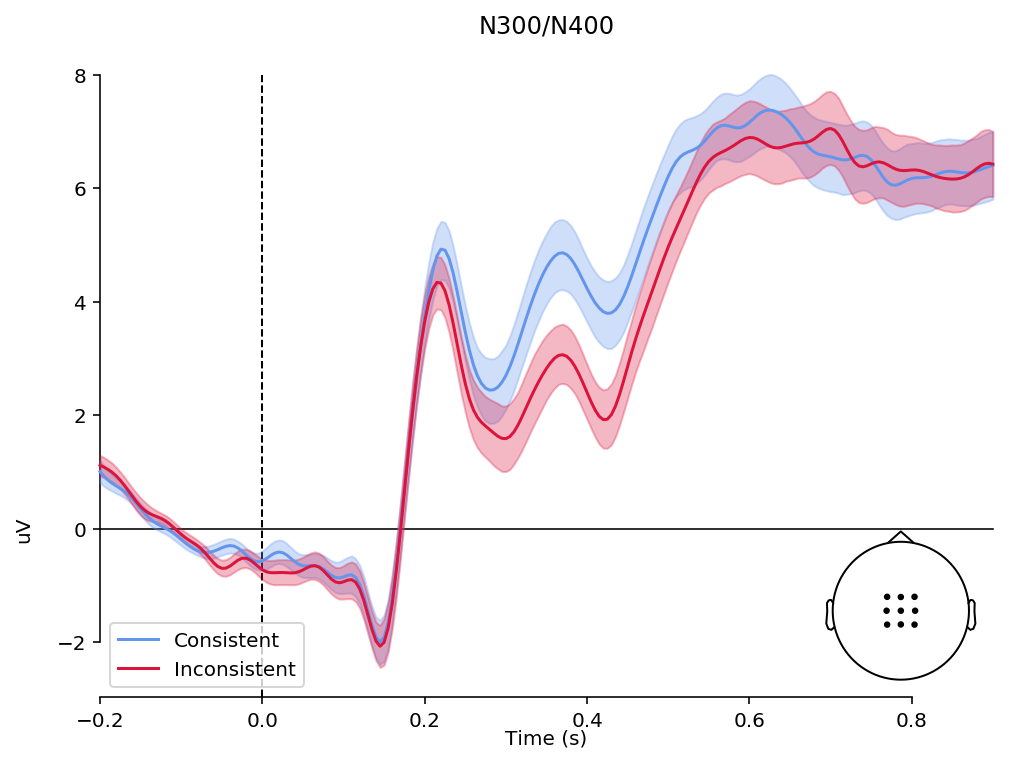

In [9]:
# plot erps mid-central region
erp_plt = mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=picks,
    ci=.68, colors = ['cornflowerblue','crimson'], title="N300/N400",
    show_sensors="lower right", truncate_yaxis="max_ticks");

#erp_plt.savefig("erps.png",  transparent = True)

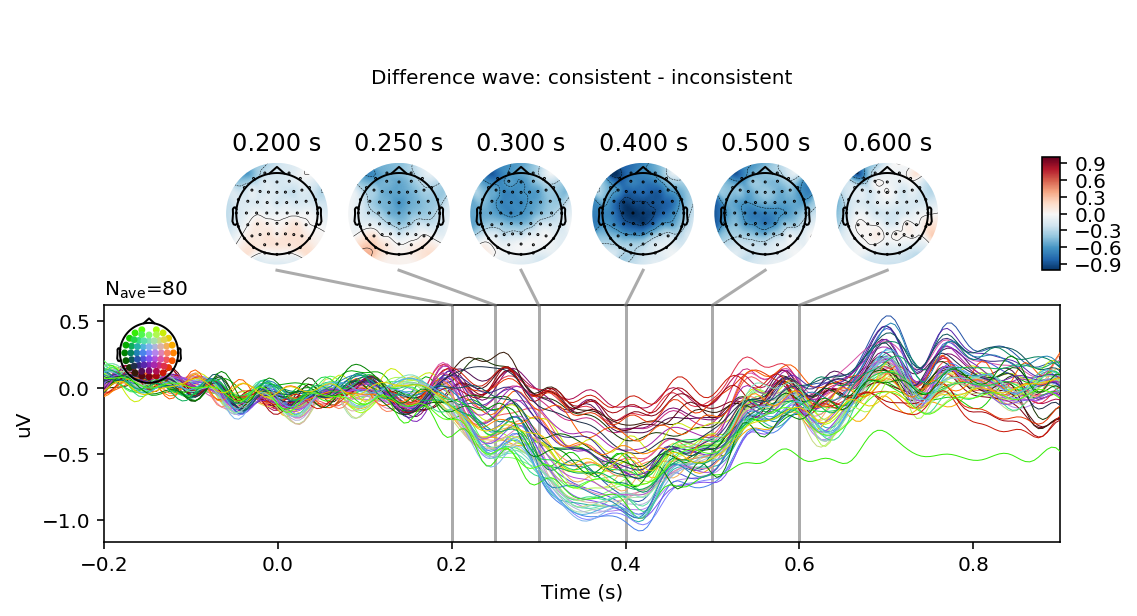

In [10]:
diff_plt = mne.combine_evoked(ga, 
                   weights=(-.5, .5)).apply_baseline(None, 0).plot_joint(
    times=[.2, .25, .3, .4, .5, .6], show=False,
#    ts_args=dict(gfp=True),
    title="Difference wave: consistent - inconsistent"#, ts_args = {'gfp': True}
);
#sns.despine(trim=True)
#diff_plt.savefig("erps_differencewave.png",  transparent = True)

## Stats

In [11]:
evoked_dict = {}
for cond in conds:
    jj=[]
    for ii, evokeds in enumerate(all_evokeds[cond]):
        print(ii, end=', ')
        jj.append(evokeds.copy().pick_channels(picked_channels).data)
    evoked_dict[cond] = jj        

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

In [12]:
# get the times
times = epochs.times

In [13]:
# take the mean per subject 
con_mean = np.mean(evoked_dict["Consistent"],1)
incon_mean = np.mean(evoked_dict["Inconsistent"],1)

# get the time windows
n3_times = (.25 < times) & (times < .35)
n4_times = (.35 < times) & (times < .5)

In [14]:
# get the 
con_n4 = con_mean[:,n4_times].mean(1)
incon_n4 = incon_mean[:,n4_times].mean(1)
con_n3 = con_mean[:,n3_times].mean(1)
incon_n3 = incon_mean[:,n3_times].mean(1)

In [15]:
stats.ttest_rel(con_n3, incon_n3, nan_policy='propagate')

Ttest_relResult(statistic=4.516873068691908, pvalue=5.6744419636532904e-05)

In [16]:
stats.ttest_rel(con_n4, incon_n4, nan_policy='propagate')

Ttest_relResult(statistic=5.084735163040805, pvalue=9.58235582780458e-06)

# MVPA

In [17]:
from mne.decoding import (GeneralizingEstimator, SlidingEstimator, Vectorizer, TimeFrequency, 
                          cross_val_multiscore, UnsupervisedSpatialFilter, Scaler,
                          LinearModel, get_coef)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
#from sklearn.model_selection import cross_val_predict, cros

In [18]:
est = make_pipeline(
    StandardScaler(),
    LinearModel(LogisticRegression(class_weight="balanced")),
)
sl = SlidingEstimator(est, scoring="roc_auc")
gest = GeneralizingEstimator(est, scoring="roc_auc")

In [19]:
def get_patterns(epochs):
    sl.fit(epochs.get_data(), epochs.events[:, -1] == event_id["Consistent"])
    coef = mne.decoding.get_coef(sl, 'patterns_', inverse_transform=False)
    return mne.EvokedArray(-coef, epochs.info, tmin=epochs.times[0])

### Plot model patterns

In [20]:
all_patterns = []
for ii, epochs in enumerate(all_epochs):
    print(ii, end=', ')
    all_patterns.append(get_patterns(epochs))

0, 
1, 
2, 
3, 
4, 
5, 
6, 
7, 
8, 
9, 
10, 
11, 
12, 
13, 
14, 
15, 
16, 
17, 
18, 
19, 
20, 
21, 
22, 
23, 
24, 
25, 
26, 
27, 
28, 
29, 
30, 
31, 
32, 
33, 
34, 
35, 
36, 
37, 
38, 
39, 


Text(0.5,0.98,'Decoding patterns')

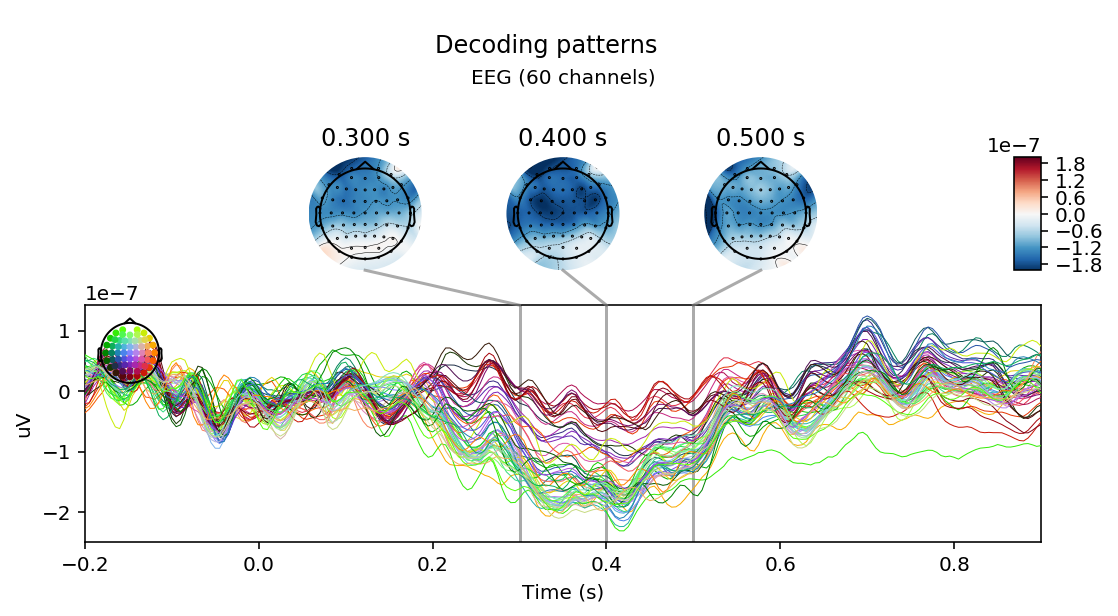

In [21]:
scaling_dict = dict(scalings=dict(eeg=1e-6))
fig = mne.grand_average(all_patterns).plot_joint(show=False,
    times=[.3, .4, .5, .7], ts_args=scaling_dict, topomap_args=scaling_dict);
ax = fig.axes[0]
ax.texts.pop(1)
fig.suptitle("Decoding patterns")
#fig.savefig("../figs/patterns_plots.pdf", bbox_inches="tight")

In [22]:
def get_scores(epochs):
    X = epochs.get_data()
    y = epochs.events[:, -1] == event_id["Consistent"]
    scores = cross_val_multiscore(sl, X, y, cv=5, n_jobs=5
                                 )
    return scores

In [23]:
def get_scores_gen(epochs):
    X = epochs.get_data()
    y = epochs.events[:, -1] == event_id["Consistent"]
    scores = cross_val_multiscore(gest, X, y, cv=5, n_jobs=5,
                                 )
    return scores

In [24]:
do_preproc = True
if do_preproc:
    all_scores = []
    for ii, epochs in enumerate(all_epochs):
        print(ii, end=', ')
        all_scores.append(get_scores(epochs))
    # save scores
    #np.save("../tmp/decoding_results.npy", np.array(all_scores))
else:            
    all_scores = np.load("../tmp/decoding_results.npy")
len(all_scores)  

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

40

## Time Gen

In [25]:
do_preproc = True
if do_preproc:
    all_scores_gets = []
    for ii, epochs in enumerate(all_epochs):
        print(ii, end=', ')
        all_scores_gets.append(get_scores_gen(epochs))
    #np.save("../tmp/decoding_gen_results.npy", np.array(all_scores_gets))
else:            
    all_scores_gets = np.load("../tmp/decoding_gen_results.npy")

len(all_scores_gets) 

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

40

# Temporal evolution of components

In [26]:
# substract chance level from values to test against 0! 
X_erp = np.mean(all_scores_gets, 1) - .5

In [27]:
from mne.stats import permutation_cluster_1samp_test

threshold = -stats.distributions.t.ppf(0.05, len(X_erp) - 1)
tfce = dict(start=0, step=0.2)

# substract chance level from values to test against 0! 
diag_activity = np.mean(all_scores, 1) - .5
diag_pvs = permutation_cluster_1samp_test(
    diag_activity[:, :, np.newaxis], tfce, out_type="mask", n_permutations=1024 * 2)[2]

## traditional time-windows 

In [28]:
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test

# component bins
time_wins = {"N300": (.25, .35), "N400": (.35, .5)}

get_tmask = lambda tmin, tmax: (tmin < times) & (times < tmax)

masks_ts = dict()
for name, times_ in time_wins.items():
    # take the mean per subject for each time window
    time_win = get_tmask(*times_)
    mean_activity = X_erp[:, time_win, :].mean(1)
    # run cluster test vs 0 and vs each other
    pvs = permutation_cluster_1samp_test(
        mean_activity[:, :, np.newaxis], tfce, out_type="mask", n_permutations=1024 * 1)[2]
    masks_ts[name] = pvs

cluster_pv_n3vs4 = permutation_cluster_test(
    [X_erp[:, get_tmask(*time_wins["N300"]), :].mean(1)[:, :, np.newaxis],
     X_erp[:, get_tmask(*time_wins["N400"]), :].mean(1)[:, :, np.newaxis]],
    tfce, out_type="mask", n_permutations=1024 * 1)[2]
assert((cluster_pv_n3vs4 > .05).all())

In [29]:
def prepare_ts_plot(ax, title, ylim):
    ax.axvline(0, color='grey', linestyle='--')
    ax.legend()
    ax.set_ylim(*ylim)
    if ax.is_first_col():
        ax.set_ylabel('Decoding > chance (%)')
    ax.set_xlabel("Time (s)")
    ax.set_title(title)
    sns.despine(trim=True, ax=ax)

def ts_plot(ax, data, cond, color, mask, vlinemax, label, ii=0):
    sns.tsplot(data, time=times, condition=cond,
               color=color, ax=ax, ci=[95])
    # plot significance test
    ax.scatter(times[mask], -np.ones(mask.sum()) - ii * .25, color=color, s=2)
    ax.vlines(times[mask][[0, -1]], -1 - ii * .25,
              vlinemax, color=color, linestyle='--', lw=1, label=label)

In [30]:
names = ("N300", "N400")
diff = np.array([X_erp[:, get_tmask(*time_wins[name1]), :][:, :, get_tmask(*time_wins[name2])].mean((1, 2)) * 100
                 for name1 in names for name2 in names])
name_pairs = [(name1 + "->" + name2) for name1 in names for name2 in names]

In [111]:
df_singlesubj = df = pd.DataFrame(diff.T, columns=name_pairs)
df["Subject"] = df.index + 1
df = df.melt(value_vars=name_pairs, id_vars="Subject",
             var_name="Classifier pattern",
             value_name="Mean decoding > chance")
df["Tested time window"] = df["Classifier pattern"].str[6:]
df["Classifier pattern"] = df["Classifier pattern"].str[:4]
df.head()

,Subject,Classifier pattern,Mean decoding > chance,Tested time window
0,1,N300,2.387060,N300
1,2,N300,-0.060555,N300
2,3,N300,7.346056,N300
3,4,N300,-2.337915,N300
4,5,N300,1.853291,N300


In [32]:
from mne.stats.permutations import _bootstrap_ci

In [33]:
diffs = np.subtract(*pd.DataFrame(diff.T, columns=name_pairs)[
    ["N300->N300", "N400->N300"]].values.T)
diff_ci = _bootstrap_ci(diffs)
print("N300 classifier home advantage, mean and 95% CI", diffs.mean(), diff_ci)

N300 classifier home advantage, mean and 95% CI 0.032323412375175845 [-0.68464314  0.68948169]


In [34]:
diffs = np.subtract(*pd.DataFrame(diff.T, columns=name_pairs)[
    ["N400->N400", "N300->N400"]].values.T)
diff_ci = _bootstrap_ci(diffs)
print("N400 classifier home advantage, mean and 95% CI", diffs.mean(), diff_ci)

N400 classifier home advantage, mean and 95% CI 1.4585790753605268 [0.73710073 2.22292235]


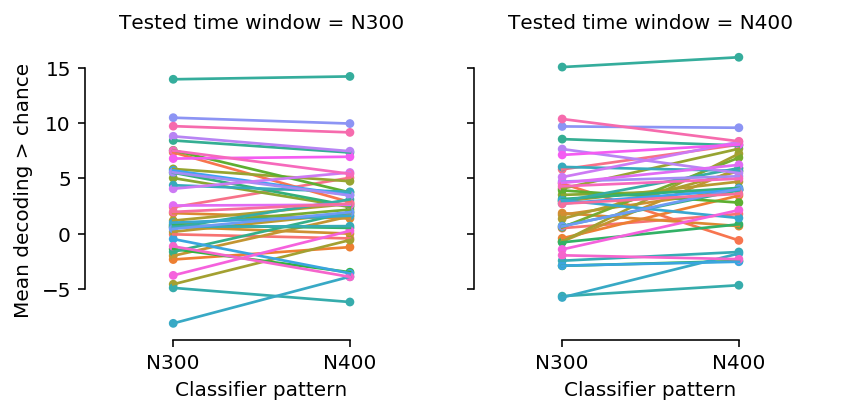

In [35]:
g = sns.FacetGrid(hue="Subject", col="Tested time window", data=df)
g.map(sns.pointplot, "Classifier pattern", "Mean decoding > chance",
      order=names, dodge=False, scale=.5)
g.despine(trim=True)

In [36]:
def plot_image(data, times, mask=None, contour_mask=None,
               ax=None, vmax=None, vmin=None,
               draw_mask=None, draw_contour=None, colorbar=True, title="",
               draw_diag=True, draw_zerolines=True, xlabel="Time (s)", ylabel="Time (s)",
               cbar_unit="%", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r"):
    """Return fig and ax for further styling, e.g., titles"""
    if ax is None:
        fig = plt.figure()
        ax = plt.axes()
    else:
        fig = ax.figure

    if vmax is None:
        vmax = np.abs(data).max()
    if vmin is None:
        vmax = np.abs(data).max()
        vmin = -vmax
    tmin, tmax = xlim = times[0], times[-1]
    extent = [tmin, tmax, tmin, tmax]
    im_args = dict(interpolation='nearest', origin='lower',
                   extent=extent, aspect='auto', vmin=vmin, vmax=vmax)

    if mask is not None:
        draw_mask = True if draw_mask is None else draw_mask
        draw_contour = True if draw_contour is None else draw_contour
    if any((draw_mask, draw_contour,)):
        if mask is None:
            raise ValueError("No mask to show!")

    if draw_mask:
        ax.imshow(data, alpha=mask_alpha, cmap=mask_cmap, **im_args)
        im = ax.imshow(
            np.ma.masked_where(~mask, data), cmap=cmap, **im_args)
    else:
        im = ax.imshow(data, cmap=cmap, **im_args)
    if draw_contour and np.unique(mask).size == 2:
        big_mask = np.kron(contour_mask, np.ones((10, 10)))
        ax.contour(big_mask, colors=["k"], extent=extent, linewidths=[.75],
                   corner_mask=False, antialiased=False, levels=[.5])
#        big_mask = np.kron(mask, np.ones((10, 10)))
#        ax.contour(big_mask, colors=["k"], extent=extent, linewidths=[.25],
#                   color="grey",
#                   corner_mask=False, antialiased=False, levels=[.5])
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)

    if draw_diag:
        ax.plot((tmin, tmax), (tmin, tmax), color="grey", linestyle=":")
    if draw_zerolines:
        ax.axhline(0, color="grey", linestyle=":")
        ax.axvline(0, color="grey", linestyle=":")

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    if colorbar:
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel(cbar_unit)

    ax.set_aspect(1./ax.get_data_ratio())

    return fig

### Stats for Time Gen

In [ ]:
from mne.viz.utils import _prepare_joint_axes

do_preproc = True
if do_preproc:
    from mne.stats import spatio_temporal_cluster_1samp_test, ttest_1samp_no_p
    from scipy import stats

    from scipy import stats
    threshold = -stats.distributions.t.ppf(0.05, len(X_erp) - 1)
    tfce = dict(start=0, step=0.2)

    t_obs, clusters, cluster_pv_erp, H0 = res = spatio_temporal_cluster_1samp_test(
        X_erp, tfce, out_type="mask",
        n_permutations=1024 * 1)
    pvs_gat = cluster_pv_erp.reshape(t_obs.shape)
#    np.save("../tmp/decoding_gat_results.npy", pvs_gat)
else:
    pvs_gat = np.load("../tmp/decoding_gat_results.npy")

Provided stat_fun does not treat variables independently. Setting buffer_size to None.


<ipython-input-37-185760f54b8f>:14: RuntimeWarning: Provided stat_fun does not treat variables independently. Setting buffer_size to None.
  n_permutations=1024 * 1)


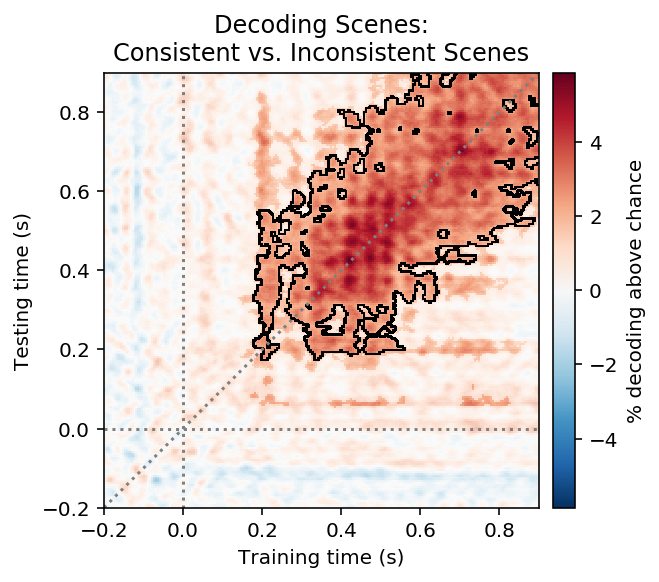

In [49]:
d = X_erp.mean(0) * 100
vmax = np.abs(d).max()
f = plot_image(
    d, times, mask=pvs_gat < .05, contour_mask=pvs_gat < .01,
    ax=None, vmax=vmax, vmin=-vmax,
    draw_mask=True, draw_contour=True, colorbar=True, title="Decoding Scenes:\nConsistent vs. Inconsistent Scenes",
    draw_diag=True, draw_zerolines=True, xlabel="Training time (s)", ylabel="Testing time (s)",
    cbar_unit="% decoding above chance", cmap="RdBu_r", mask_alpha=.5, mask_cmap="RdBu_r")

/home/jona/tools/miniconda3/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


Text(0.5,0.98,'ERP,Inconsistent minus consistent Scenes')

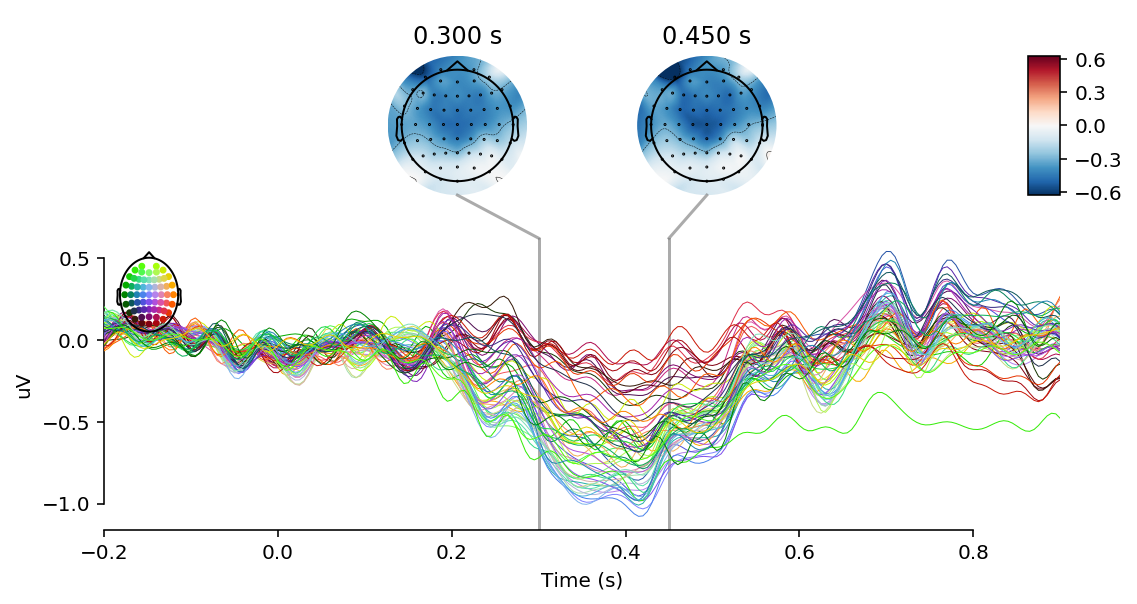

In [50]:
ga_ = mne.combine_evoked(ga, weights=(-.5, .5))
ga_.nave = None
ga_.apply_baseline(None, 0).plot_joint(
    ts_args={"time_unit": "s"},
    topomap_args={"time_unit": "s", "average": .5},
    times=[.3, .45], show=False, title=None);
sns.despine(trim=True)
fig.suptitle("ERP,Inconsistent minus consistent Scenes")

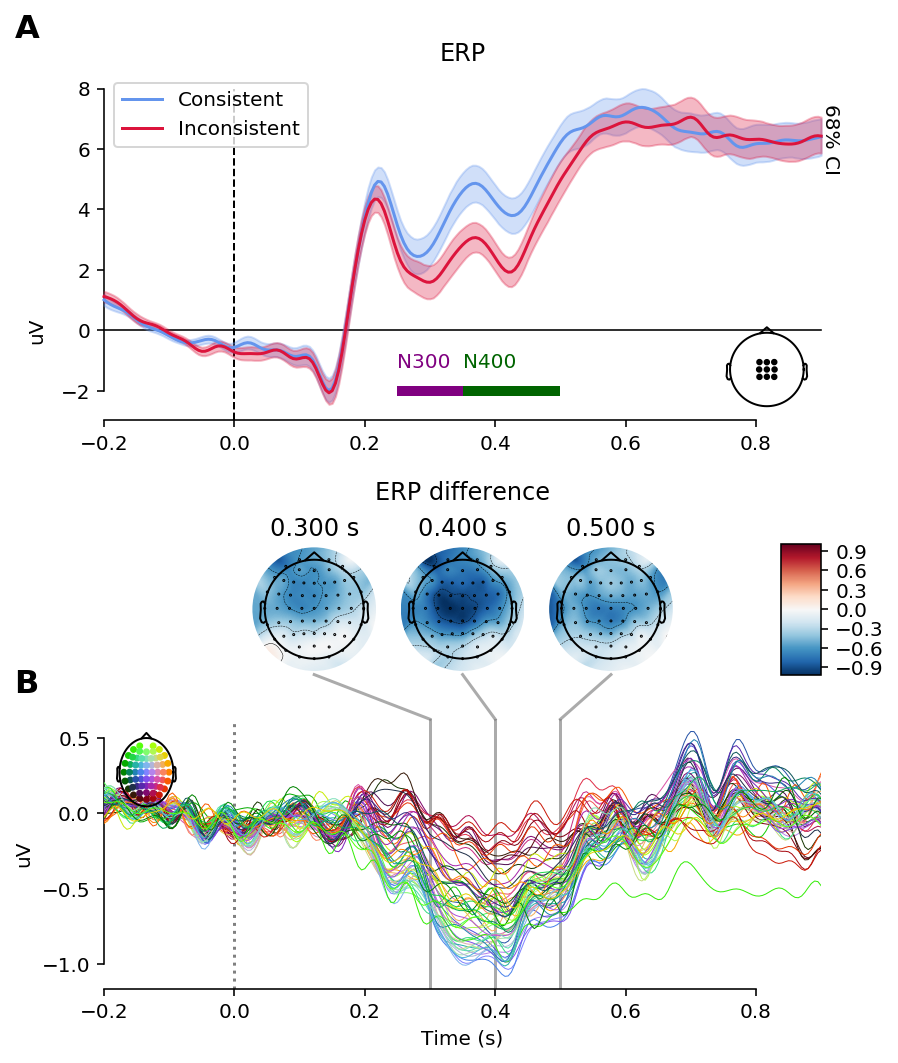

In [63]:
from mne.viz.utils import _prepare_joint_axes

topo_times = [.3, .4, .5, .7]
n_maps = len(topo_times)
ts = (n_maps + 2)

fig = plt.figure(figsize=(6, 6))
erp_ax = plt.subplot2grid((5, 1), (0, 0), rowspan=2)

main_ax = fig.add_subplot(313)
map_ax = [plt.subplot(6, ts, x + 2 + (ts * 3)) for x in range(n_maps)]

# Position topomap subplots on the second row, starting on the
# second column
cbar_ax = plt.subplot(6, ts * 3, 6 + 4 + (ts * 10))

ga_diff = mne.combine_evoked(ga, weights=(-.5, .5)).apply_baseline(None, 0)
ga_diff.nave = None
ga_diff.plot_joint(
    ts_args={"axes": main_ax, "time_unit": "s"},
    topomap_args={"axes": list(map_ax) + [cbar_ax], "time_unit": "s"},
    times=topo_times, show=False, title=None);
main_ax.set_title("ERP difference", pad=110)
main_ax.text(-.125, 1.1, "B", weight="bold", fontsize=16, transform=main_ax.transAxes)
main_ax.axvline(0, linestyle=":", color="grey")
sns.despine(trim=True, ax=main_ax)

# plot erps mid-central region
mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=[all_epochs[0].ch_names.index(ch_name) for ch_name in picked_channels],
    ci=.68, colors = ['cornflowerblue','crimson'], title="ERP", show=False,
    show_legend="upper left",
    show_sensors="lower right", truncate_yaxis="max_ticks", axes=erp_ax);
erp_ax.set_xlabel('')
erp_ax.text(-.125, 1.1, "A", weight="bold", fontsize=16, transform=erp_ax.transAxes)
erp_ax.text(x=.9, y=7, s="68% CI", rotation=270)

erp_ax.hlines(-2, .25, .35, color="purple", label="N300", linewidth=5)
erp_ax.hlines(-2, .35, .5, color="darkgreen", label="N400", linewidth=5)
erp_ax.text(.25, -1.25, "N300", transform=erp_ax.transData, color="purple")
erp_ax.text(.35, -1.25, "N400", transform=erp_ax.transData, color="darkgreen")

fig.savefig("../figs/erp_plot.pdf", bbox_inches="tight")

In [52]:
def ts_plot_flat(ax, data, cond, color, mask, vlinemax, label, ii=0):
    sns.tsplot(data, time=times, condition=cond,
               color=color, ax=ax, ci=[95])
    # plot significance test
    ax.scatter(times[mask], -np.ones(mask.sum()) - ii * .25, color=color, s=2)

/home/jona/tools/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/jona/tools/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/jona/tools/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


Text(-0.15,1.075,'A')

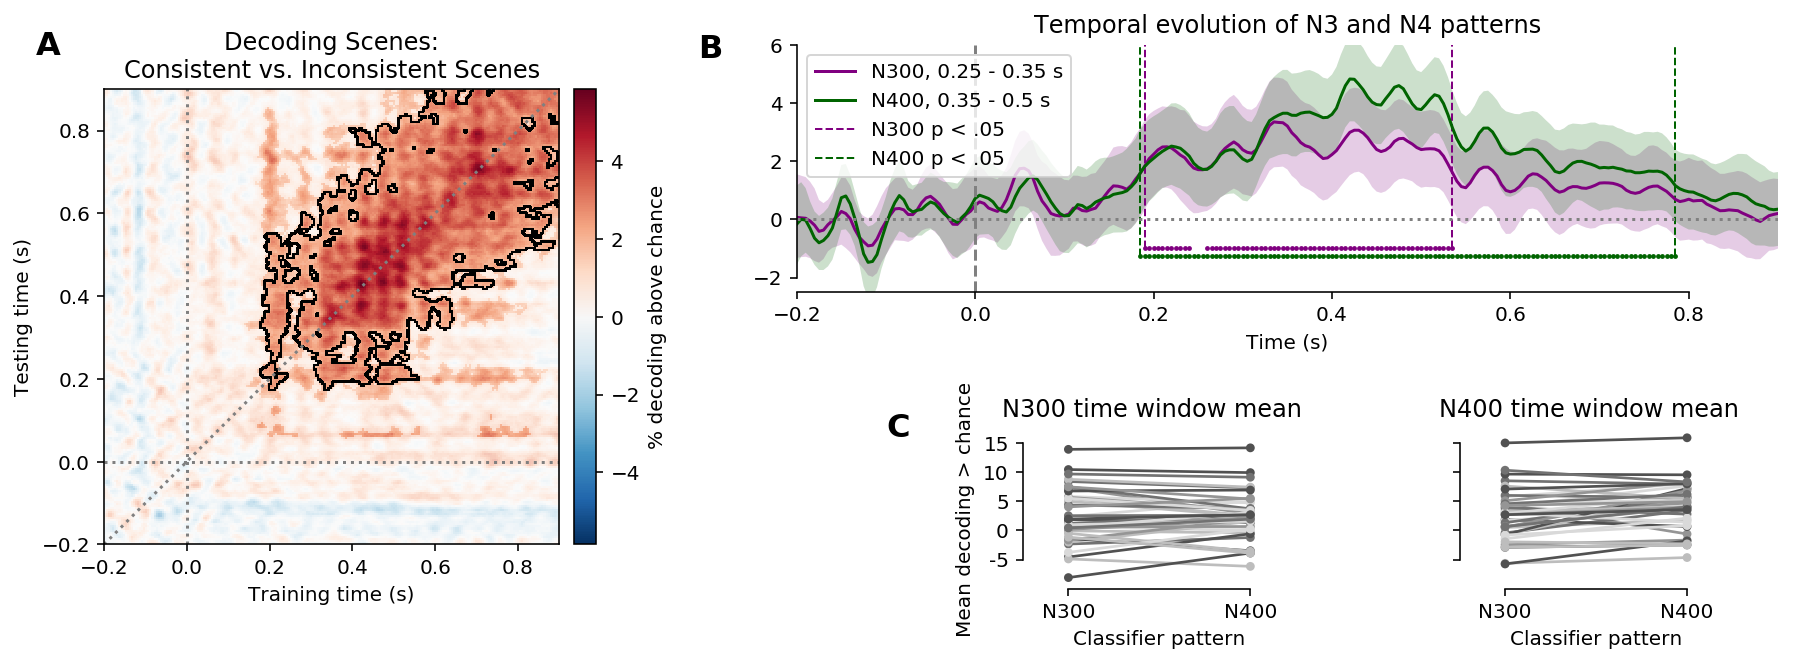

In [57]:
fig, axes = plt.subplots(ncols=4, nrows=3, figsize=(15, 5))
ts_ax = plt.subplot2grid((2, 5), (0, 2), colspan=3)
gat_ax = plt.subplot(131)
n3_ax, n4_ax = axes.flatten()[[-2, -1]]
axes.flatten()[-3].axis("off")

# diagonal decoding
vlinemax = 8.5

# n3 and n4 decoding
vlinemax = 6.5

colors = {"N300": "purple", "N400": "darkgreen"}

for ii, name in enumerate(("N300", "N400")):
    color = colors[name]
    data = X_erp[:, get_tmask(*time_wins[name]), :].mean(1) * 100
    cond = "{}, {} - {} s".format(name, *time_wins[name])

    mask = masks_ts[name] < .05
    label = name + ' p < .05'
    ts_plot(ts_ax, data, cond, color, mask, vlinemax, label, ii)
ts_ax.axhline(0, color='grey', linestyle=':')
prepare_ts_plot(ts_ax, 'Temporal evolution of N3 and N4 patterns', (-2.5, vlinemax - .5))

# the following is stupidly complicated because of a weird bug with zorder.
# otherwise it would just be a nice sns.facetgrid job
for ax, name, color in zip((n3_ax, n4_ax), names, colors):
    df_ = df[df["Tested time window"] == name]
    sns.pointplot(x="Classifier pattern", y="Mean decoding > chance",
                  hue="Subject", col="Tested time window", data=df_,
                  palette=sns.color_palette("Greys", 7)[1:-1], ax=ax,
                  order=names, dodge=False, scale=.5)
    ax.set_title(name + " time window mean  ")
    ax.set_yticks([-5, 0, 5, 10, 15])
#    ax.set_xlim(-.1, 1.5)
    if not ax.is_last_col():
        ax.set_yticklabels([-5, 0, 5, 10, 15])
    else:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    ax.set_ylim([-10, 17.5])
    ax.legend([], frameon=False)
    ax.spines["left"].set_position(("axes", .125))

sns.despine(ax=n3_ax, trim=True)
sns.despine(ax=n4_ax, trim=True)

ts_ax.text(-.1, .95, "B", fontsize=16, fontweight='bold', transform=ts_ax.transAxes)
n3_ax.text(-.25, .95, "C", fontsize=16, fontweight='bold', transform=n3_ax.transAxes)

#plt.tight_layout()

d = X_erp.mean(0) * 100
vmax = np.abs(d).max()
f = plot_image(
    d, times, mask=pvs_gat < .05, contour_mask=pvs_gat < .01,
    ax=gat_ax, vmax=vmax, vmin=-vmax,
    draw_mask=True, draw_contour=True, colorbar=True,
    title="Decoding Scenes:\nConsistent vs. Inconsistent Scenes",
    draw_diag=True, draw_zerolines=True,
    ylabel="Testing time (s)", xlabel="Training time (s)",
    mask_alpha=.5, mask_cmap="RdBu_r", cmap="RdBu_r",
    cbar_unit="% decoding above chance")

gat_ax.text(-.15, 1.075, "A", fontsize=16, fontweight='bold', transform=gat_ax.transAxes)

#fig.savefig("../figs/n3n4_plots.pdf", bbox_inches="tight")

/home/jona/tools/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/jona/tools/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


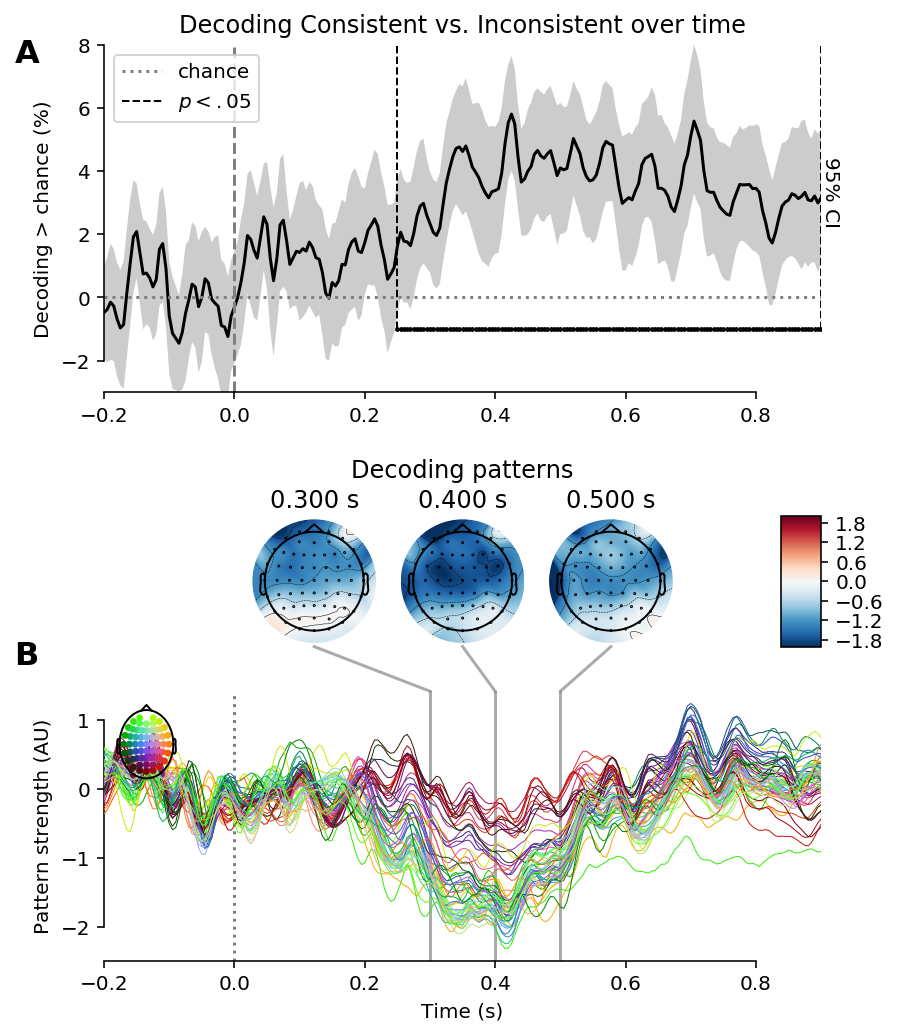

In [69]:
topo_times = [.3, .4, .5, .7]
n_maps = len(topo_times)
ts = (n_maps + 2)

fig = plt.figure(figsize=(6, 6))
diag_ax = plt.subplot2grid((5, 1), (0, 0), rowspan=2)#fig.add_subplot(311)

main_ax = fig.add_subplot(313)
map_ax = [plt.subplot(6, ts, x + 2 + (ts * 3)) for x in range(n_maps)]

# Position topomap subplots on the second row, starting on the
# second column
cbar_ax = plt.subplot(6, ts * 3, 6 + 4 + (ts * 10))

# diagonal decoding
vlinemax = 8.5
ts_plot(diag_ax, diag_activity * 100, None, "k", diag_pvs < .05, vlinemax, "$p < .05$")
diag_ax.axhline(0, color='grey', linestyle=':', label='chance')
prepare_ts_plot(diag_ax, 'Decoding Consistent vs. Inconsistent over time', (-3, vlinemax - .5))
diag_ax.set_xlabel("")
diag_ax.text(x=.9, y=4, s="95% CI", rotation=270)

diag_ax.text(-.125, .95, "A", fontsize=16, fontweight='bold', transform=diag_ax.transAxes)

scaling_dict = dict(scalings=dict(eeg=10))
gav_patterns = mne.grand_average(all_patterns)
gav_patterns.nave = None
gav_patterns.plot_joint(
    ts_args={"axes": main_ax, "time_unit": "s", **scaling_dict},
    topomap_args={"axes": list(map_ax) + [cbar_ax], "time_unit": "s", **scaling_dict},
    times=topo_times, show=False, title=None);

main_ax.set_title("Decoding patterns", pad=107)
main_ax.set_ylabel("Pattern strength (AU)")
main_ax.text(-.125, 1.1, "B", fontsize=16, fontweight='bold', transform=main_ax.transAxes)
main_ax.axvline(0, linestyle=":", color="grey")

sns.despine(trim=True, ax=main_ax)

#plt.tight_layout()

fig.savefig("../figs/decoding_plots.pdf", bbox_inches="tight")

/home/jona/tools/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/jona/tools/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


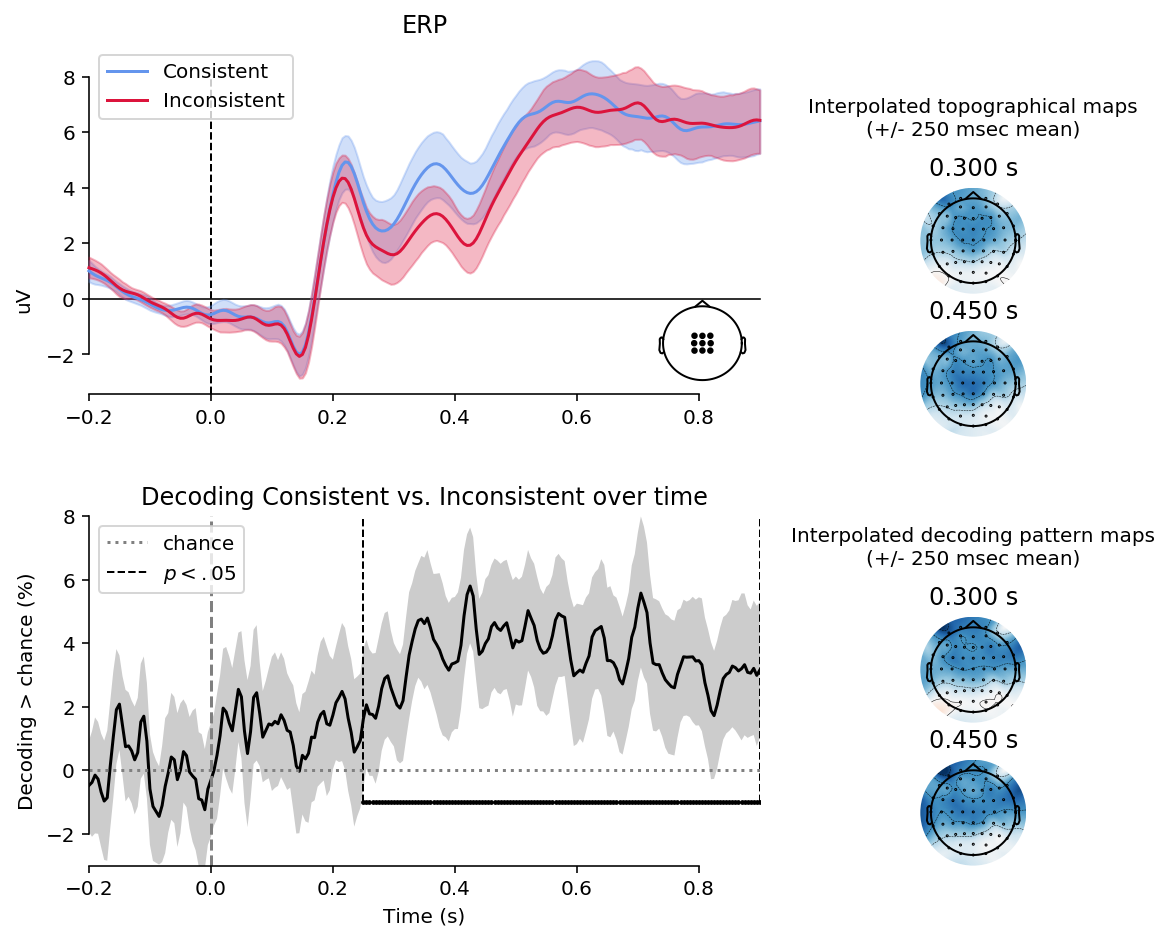

In [65]:
from mne.viz.utils import _prepare_joint_axes

fig = plt.figure(figsize=(8, 6))
erp_ax = plt.subplot2grid((2, 3), (0, 0), colspan=2)
time_axes = [plt.subplot(636), plt.subplot(639)]

ga_diff = mne.combine_evoked(ga, weights=(-.5, .5)).apply_baseline(None, 0)
ga_diff.nave = None
ga_diff.plot_topomap(times=[.3, .45], outlines="skirt", vmax=1, vmin=-1,
                     average=0.25, axes=time_axes, show=False, colorbar=False),
time_axes[0].text(0, 1.25, "Interpolated topographical maps\n(+/- 250 msec mean)",
                 horizontalalignment='center')

mne.viz.plot_compare_evokeds(
    all_evokeds,
    picks=[all_epochs[0].ch_names.index(ch_name) for ch_name in picked_channels],
    ci=.95, colors = ['cornflowerblue','crimson'], title="ERP", show=False,
    show_legend="upper left",
    show_sensors="lower right", truncate_yaxis="max_ticks", axes=erp_ax);
erp_ax.set_xlabel("")

diag_ax = plt.subplot2grid((2, 3), (1, 0), colspan=2)

# diagonal decoding
vlinemax = 8.5
ts_plot(diag_ax, diag_activity * 100, None, "k", diag_pvs < .05, vlinemax, "$p < .05$")
diag_ax.axhline(0, color='grey', linestyle=':', label='chance')
prepare_ts_plot(diag_ax, 'Decoding Consistent vs. Inconsistent over time', (-3, vlinemax - .5))
#diag_ax.set_xticklabels([])
#diag_ax.set_xlabel("")

time_axes = [plt.subplot(6, 3, 15),
             plt.subplot(6, 3, 18)]

gav_patterns = mne.grand_average(all_patterns)
gav_patterns.nave = None
gav_patterns.plot_topomap(times=[.3, .45], outlines="skirt", vmax=200000, vmin=-200000,
                     average=0.25, axes=time_axes, show=False, colorbar=False),
time_axes[0].text(0, 1.25, "Interpolated decoding pattern maps\n(+/- 250 msec mean)",
                 horizontalalignment='center')

fig.subplots_adjust(hspace=0.35)

#fig.savefig("../figs/time_stuff.pdf", bbox_inches="tight")

In [70]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score

In [71]:
all_res = []
for epochs in all_epochs:
    epochs = epochs.copy().subtract_evoked()
    bigdf = epochs.to_data_frame().query("250 < time < 500")

    res = {"Consistent": 0, "Inconsistent": 0}

    for n in range(2):
        for cond in ("Consistent", "Inconsistent"):
            df = bigdf.query("condition == @cond")
            X1 = df.query("time > 350").groupby("epoch").mean().values[(n+1)-1::2]
            X2 = df.query("time < 350").groupby("epoch").mean().values[1-n::2]
            X = np.vstack((X1, X2))
            y = [False] * len(X1) + [True] * len(X2)
            groups = np.hstack((np.arange(len(X1)), np.arange(len(X2)))) + 1
            res[cond] += cross_val_score(LogisticRegression(class_weight="balanced"),
                                        X, y, groups=groups, scoring="roc_auc",
                                        cv=StratifiedKFold(5, shuffle=True)).mean() / 2

    all_res.append(res)

In [72]:
decode_timewins = pd.DataFrame(all_res).melt(value_name="Decoding Accuracy", var_name="Condition")

In [74]:
stats.wilcoxon(decode_timewins.query("Condition == 'Consistent'")["Decoding Accuracy"].values - .5)

WilcoxonResult(statistic=348.0, pvalue=0.4046414825718154)

In [75]:
stats.wilcoxon(decode_timewins.query("Condition == 'Inconsistent'")["Decoding Accuracy"].values - .5)

WilcoxonResult(statistic=387.0, pvalue=0.7572075493926324)

In [89]:
cv = StratifiedKFold(10, shuffle=True)

all_res_2 = []
for ii, epochs in enumerate(all_epochs):
    print(ii, end=", ")
    epochs = epochs.copy().subtract_evoked()
    bigdf = epochs.to_data_frame().query("250 < time < 500")

    res = dict()
    y = epochs.events[:, -1] == event_id["Inconsistent"]
    X1 = bigdf.query("time < 350").groupby("epoch").mean().values
    X2 = bigdf.query("time > 350").groupby("epoch").mean().values
    res["N3->N3"] = cross_val_score(LogisticRegression(class_weight="balanced"),
                                 X1, y, scoring="roc_auc",
                                 cv=cv).mean()
    res["N4->N4"] = cross_val_score(LogisticRegression(class_weight="balanced"),
                                 X2, y, scoring="roc_auc",
                                 cv=cv).mean()
    
    n3n4, n4n3 = [], []
    for train, test in cv.split(X1, y):
        n3n4.append(LogisticRegression(class_weight="balanced").fit(X1[train], y[train]).score(X2[test], y[test]))
        n4n3.append(LogisticRegression(class_weight="balanced").fit(X2[train], y[train]).score(X1[test], y[test]))
    res["N3->N4"] = np.mean(n3n4)
    res["N4->N3"] = np.mean(n4n3)

    all_res_2.append(res)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 

In [90]:
decode_timebins = pd.DataFrame(all_res_2).melt(value_name="Decoding Accuracy", var_name="Condition")
decode_timebins["From"], decode_timebins["To"] = decode_timebins.Condition.str.split("->", expand=True).values.T

In [126]:
df_singlesubj_diff = pd.DataFrame()
df_singlesubj_diff["N3->N3 > N4->N3"] = df_singlesubj["N300->N300"] - df_singlesubj["N400->N300"]
df_singlesubj_diff["N4->N4 > N3->N4"] = df_singlesubj["N400->N400"] - df_singlesubj["N300->N400"]
df_singlesubj_diff = df_singlesubj_diff.melt(var_name="Decoding direction", value_name="Score difference")
df_singlesubj_diff.head()

,Decoding direction,Score difference
0,N3->N3 > N4->N3,-2.662542
1,N3->N3 > N4->N3,0.371014
2,N3->N3 > N4->N3,4.493891
3,N3->N3 > N4->N3,-1.121690
4,N3->N3 > N4->N3,0.486733


/home/jona/tools/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)
/home/jona/tools/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/jona/tools/miniconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


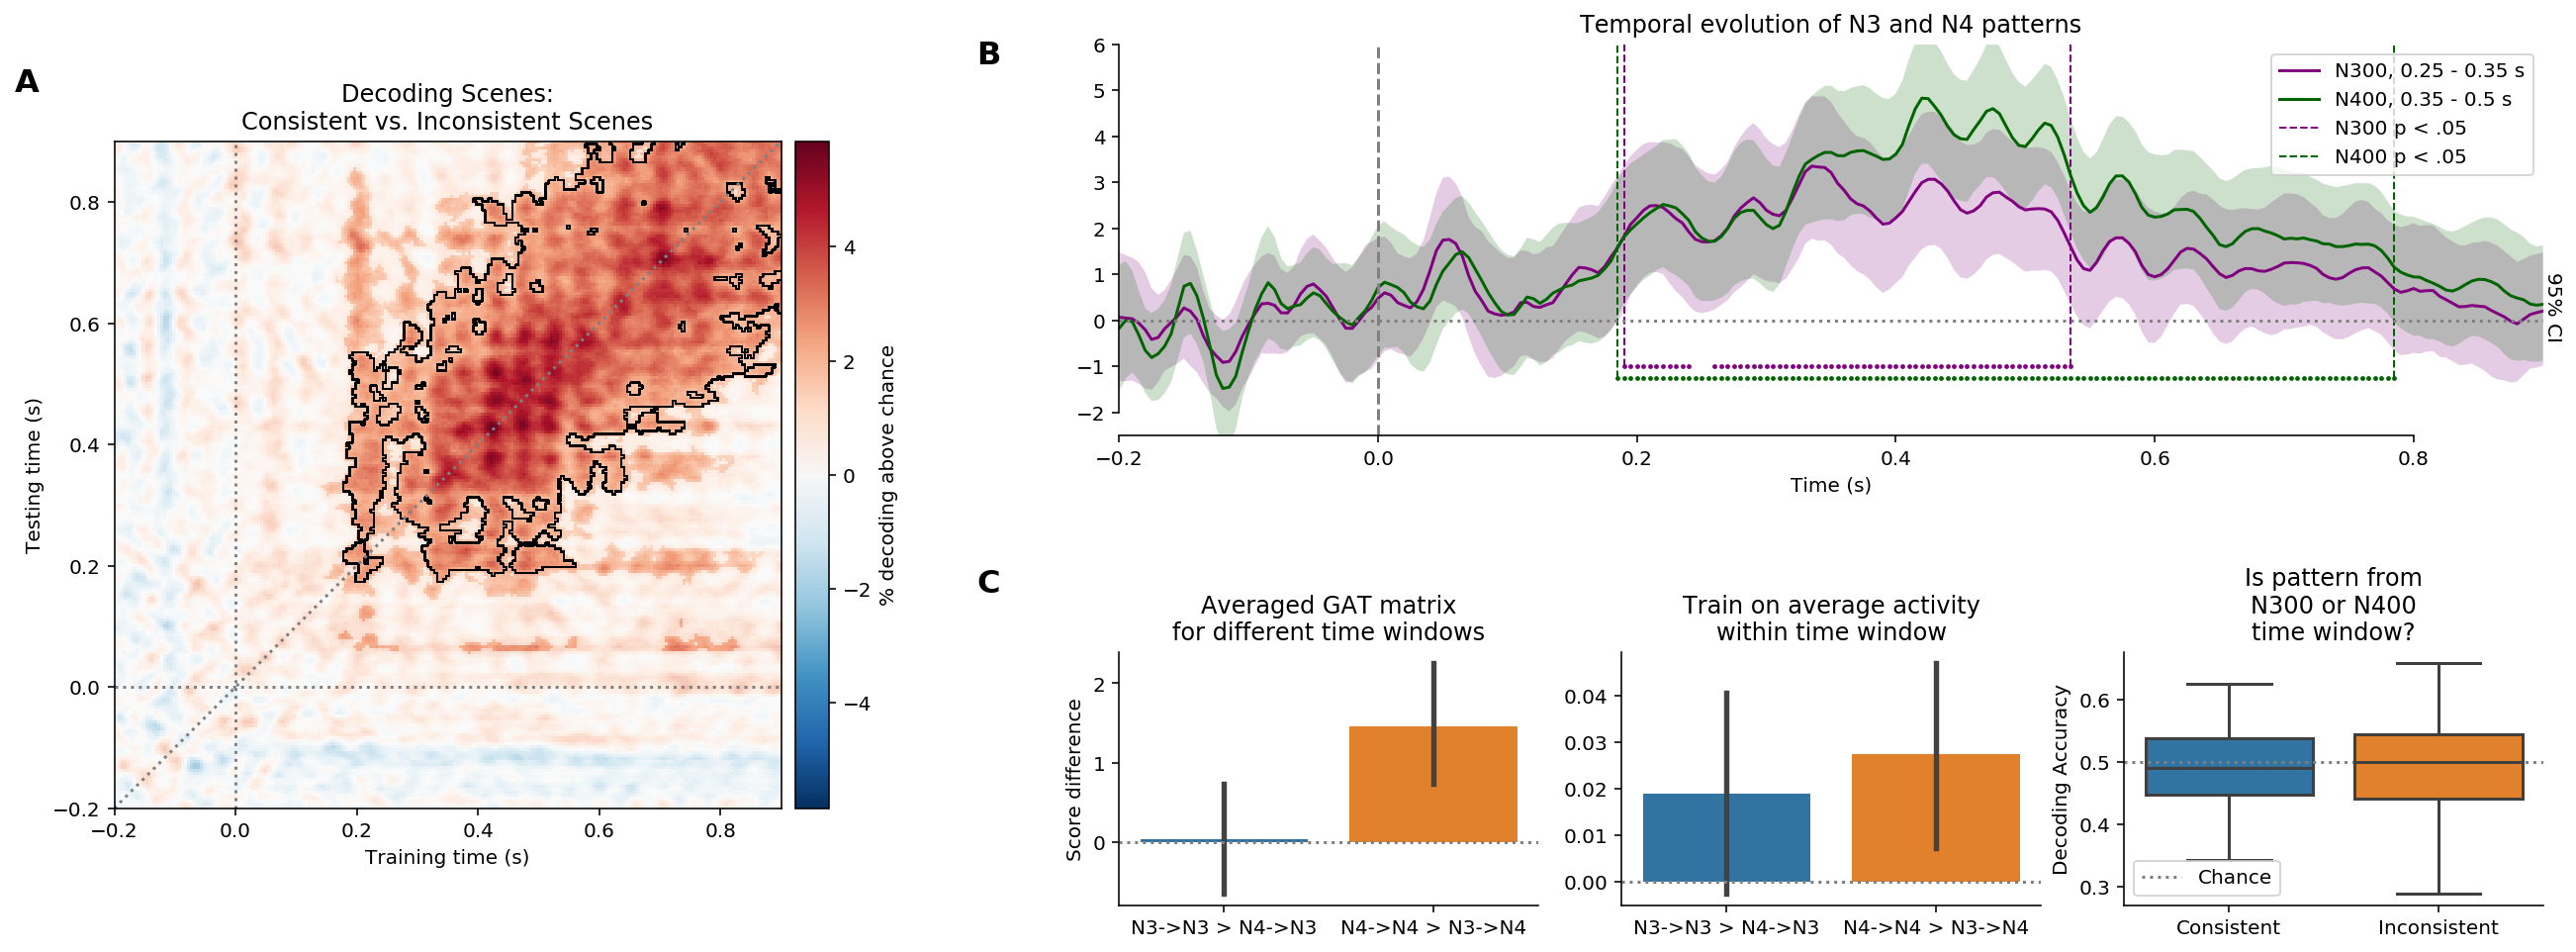

In [151]:
fig, axes = plt.subplots(ncols=5, nrows=3, figsize=(22, 8))
ts_ax = plt.subplot2grid((2, 5), (0, 2), colspan=3)
gat_ax = plt.subplot(131)
single_ax, avg_ax, decod_ax = axes.flatten()[-3:]

#plt.subplots_adjust(wspace=.8)
# diagonal decoding
vlinemax = 8.5

# n3 and n4 decoding
vlinemax = 6.5

colors = {"N300": "purple", "N400": "darkgreen"}

for ii, name in enumerate(("N300", "N400")):
    color = colors[name]
    data = X_erp[:, get_tmask(*time_wins[name]), :].mean(1) * 100
    cond = "{}, {} - {} s".format(name, *time_wins[name])

    mask = masks_ts[name] < .05
    label = name + ' p < .05'
    ts_plot(ts_ax, data, cond, color, mask, vlinemax, label, ii)
ts_ax.axhline(0, color='grey', linestyle=':')
prepare_ts_plot(ts_ax, 'Temporal evolution of N3 and N4 patterns', (-2.5, vlinemax - .5))
ts_ax.text(x=.9, y=0.75, s="95% CI", rotation=270)
ts_ax.text(-.1, .95, "B", fontsize=16, fontweight='bold', transform=ts_ax.transAxes)

d = X_erp.mean(0) * 100
vmax = np.abs(d).max()
f = plot_image(
    d, times, mask=pvs_gat < .05, contour_mask=pvs_gat < .01,
    ax=gat_ax, vmax=vmax, vmin=-vmax,
    draw_mask=True, draw_contour=True, colorbar=True,
    title="Decoding Scenes:\nConsistent vs. Inconsistent Scenes",
    draw_diag=True, draw_zerolines=True,
    ylabel="Testing time (s)", xlabel="Training time (s)",
    mask_alpha=.5, mask_cmap="RdBu_r", cmap="RdBu_r",
    cbar_unit="% decoding above chance")

gat_ax.text(-.15, 1.075, "A", fontsize=16, fontweight='bold', transform=gat_ax.transAxes)

g = sns.boxplot(x="Condition", y="Decoding Accuracy", data=decode_timewins, ax=decod_ax)
g.axhline(.5, linestyle=":", color="grey", label="Chance")
g.set_title("Is pattern from\nN300 or N400\ntime window?")
g.set_xlabel("")
g.legend()
sns.despine(ax=decod_ax)

g = sns.barplot(x="Condition", y="Decoding Accuracy Differences", data=df_agg, ax=avg_ax)
g.axhline(0, linestyle=":", color="grey")
#g.set_title("Testing 'Home Advantage'\nover time window means")
g.set_title("Train on average activity\nwithin time window")
g.set_xlabel("")
g.set_ylabel("")
sns.despine(ax=avg_ax)

g = sns.barplot(x="Decoding direction", y="Score difference", data=df_singlesubj_diff, ax=single_ax)
g.axhline(0, linestyle=":", color="grey")
#g.set_title("Testing 'Home Advantage'\nover time window means")
g.set_title("Averaged GAT matrix\nfor different time windows")
g.set_xlabel("")
g.set_xlabel("")
sns.despine(ax=single_ax)

ts_ax.text(-.1, -.4, "C", fontsize=16, fontweight='bold', transform=ts_ax.transAxes)

fig.savefig("../figs/n3n4_plots.pdf", bbox_inches="tight")